,adduct_name,adduct_smiles,warhead,binder_smiles,common_name,reaction_type,recovery_strategy,binder_type,note,covalent_record,...,aa_seq,unp_accessionid,unp_resnum,title,chain_name,binder_id,binder_atom,adduct_pdb,binder_pdb,reaction_svg
0,1XZL_A_SER_120_?_OG_?_A_HEE_901_?_P_?_cif,CCCCCC[P@](=O)([At])OCC,Phosphonate_Halogen,CCCCCC[P@@](=O)(OCC)F,NaN,Addition-Elimination,manual,inhibitor,NaN,"1XZL,A,A,SER,SER,120,120,?,OG,?,polymer,B,A,HE...",...,120,P00590,136.0,FUSARIUM SOLANI CUTINASE COMPLEX WITH N-HEXYLP...,CUTINASE,KETYPRLRZJYJOG-GFCCVEGCSA-N,HEE_P,,,"<svg viewBox=""0 0 734 264""><symbol id=""rctn1"">..."

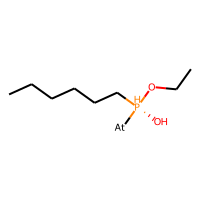
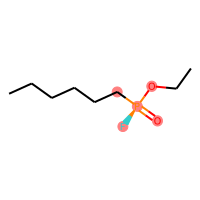

In [1]:
# pip install pickle5 pandas biopython matplotlib drawSvg bs4
import io, re, pickle5, time, math, urllib, Bio.PDB, sys, pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, PandasTools, Draw, rdDepictor
from rdkit.Chem.Draw import IPythonConsole, rdMolDraw2D
from rdkit.Geometry.rdGeometry import Point3D
PandasTools.RenderImagesInAllDataFrames(images=True)
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
from IPython.core.display import display, HTML, SVG
display(HTML("<style>.container { width:100% !important; }</style>")) 
df = pd.read_pickle('df_cov_sanitized.pkl') 

df.head(1)

In [2]:
def get_shape(root):
    _,_,width,height=root.attrib['viewBox'].split()
    return int(width), int(height) 

import xml.etree.ElementTree as ET
def drawReactionInSVG(rctn1_svg, rctn2_svg, prdct_svg): 
    rctn1_root = ET.fromstring(rctn1_svg)
    rctn2_root = ET.fromstring(rctn2_svg)
    prdct_root = ET.fromstring(prdct_svg)
    
    rctn1_width, rctn1_height = get_shape(rctn1_root)
    rctn2_width, rctn2_height = get_shape(rctn2_root)
    prdct_width, prdct_height = get_shape(prdct_root)
    
    max_height  = max([rctn1_height, rctn2_height, prdct_height,10])
    half_height = max_height/2
    full_width  = rctn1_width + 10 + rctn2_width + 40 + prdct_width 
    
    svg = ET.Element('svg', attrib={'viewBox':f'0 0 {full_width} {max_height}'})
    
    rctn1_symbol = ET.SubElement(svg, 'symbol', attrib={'id':'rctn1'}) 
    for child in rctn1_root:
        if child.tag.endswith('rect'): 
            continue#child.set('style', 'fill:black;stroke:1') 
        rctn1_symbol.append(child)
        
    plus_symbol  = ET.SubElement(svg, 'symbol', attrib={'id':'plus'})
    _ = ET.SubElement( plus_symbol, 'line', attrib={'x1':'0', 'x2':'10', 'y1': '5', 'y2': '5',   'stroke':'rgb(0, 0, 0)', 'stroke-width':'1'})
    _ = ET.SubElement( plus_symbol, 'line', attrib={'x1':'5', 'x2': '5', 'y1': '0', 'y2':'10',   'stroke':'rgb(0, 0, 0)', 'stroke-width':'1'})
    
    rctn2_symbol = ET.SubElement(svg, 'symbol', attrib={'id':'rctn2'}) 
    for child in rctn2_root:
        if child.tag.endswith('rect'): 
            continue#child.set('style', 'fill:black;stroke:1') 
        rctn2_symbol.append(child)
    
    arrow_symbol = ET.SubElement(svg, 'symbol', attrib={'id':'arrow'})
    _ = ET.SubElement(arrow_symbol, 'line', attrib={'x1':'0', 'x2': '35', 'y1':'5', 'y2': '5',   'stroke':'rgb(0, 0, 0)', 'stroke-width':'1'})
    _ = ET.SubElement(arrow_symbol, 'path', attrib={'d':'M 25 1 L 40 5 L 25 9 C 30 5 30 5 25 1', 'stroke-miterlimit':'1', 'stroke-width':'1'})
    
    prdct_symbol = ET.SubElement(svg, 'symbol', attrib={'id':'prdct'}) 
    for child in prdct_root:
        if child.tag.endswith('rect'): 
            continue#child.set('style', 'fill:black;stroke:1')  
        prdct_symbol.append(child)    
    
    _ = ET.SubElement(svg, 'use', attrib={'href': '#rctn1', 'x':'0'                                , 'y':str(half_height-rctn1_height/2)})
    _ = ET.SubElement(svg, 'use', attrib={'href':  '#plus', 'x':str(rctn1_width)                   , 'y':str(half_height-5)})
    _ = ET.SubElement(svg, 'use', attrib={'href': '#rctn2', 'x':str(rctn1_width+10)                , 'y':str(half_height-rctn2_height/2)})
    _ = ET.SubElement(svg, 'use', attrib={'href': '#arrow', 'x':str(rctn1_width+10+rctn2_width)    , 'y':str(half_height-4)})
    _ = ET.SubElement(svg, 'use', attrib={'href': '#prdct', 'x':str(rctn1_width+10+rctn2_width+40) , 'y':str(half_height-prdct_height/2)})
     
    return ET.tostring(svg, encoding="unicode")

In [3]:
op = rdMolDraw2D.MolDrawOptions() # https://rdkit.org/docs/source/rdkit.Chem.Draw.rdMolDraw2D.html?#rdkit.Chem.Draw.rdMolDraw2D.MolDrawOptions
#op.addAtomIndices=True
op.bondLineWidth=2
op.fixedBondLength=24
op.maxFontSize=18
op.minFontSize=18
op.legendFontSize=24
op.centreMoleculesBeforeDrawing=True

def MolToSVG(m):
    if not m.GetNumConformers():
        rdDepictor.Compute2DCoords(m)  
        
    drawer = rdMolDraw2D.MolDraw2DSVG(5000,5000) 
    drawer.SetDrawOptions(op)  
    drawer.DrawMolecule(m)
    drawer.FinishDrawing()
    
    _ = re.findall("(?<=d\=\').*?(?=\')",  drawer.GetDrawingText(), re.DOTALL)
    _ = ' '.join(_)
    _ = re.sub('[a-zA-Z,\n]', ' ', _) 
    _ = [float(f) for f in _.split()] 
    _ = int(max(_) - min(_)) + 1
    
    drawer = rdMolDraw2D.MolDraw2DSVG(_, _) 
    drawer.SetDrawOptions(op)  
    drawer.DrawMolecule(m)
    drawer.FinishDrawing()
    return drawer.GetDrawingText().replace('xmlns=','this_is_garbage=') 

Amino_Acids = {'ALA': 'C[C@@H](C(=O)O)N', 'ARG': 'C(C[C@@H](C(=O)O)N)CNC(=[NH2+])N', 'ASN': 'C([C@@H](C(=O)O)N)C(=O)N', 'ASP': 'C([C@@H](C(=O)O)N)C(=O)O', 'CYS': 'C([C@@H](C(=O)O)N)S', 'GLN': 'C(CC(=O)N)[C@@H](C(=O)O)N', 'GLU': 'C(CC(=O)O)[C@@H](C(=O)O)N', 'GLY': 'C(C(=O)O)N', 'HIS': 'c1c([nH+]c[nH]1)C[C@@H](C(=O)O)N', 'ILE': 'CC[C@H](C)[C@@H](C(=O)O)N', 'LEU': 'CC(C)C[C@@H](C(=O)O)N', 'LYS': 'C(CC[NH3+])C[C@@H](C(=O)O)N', 'MET': 'CSCC[C@@H](C(=O)O)N', 'PHE': 'c1ccc(cc1)C[C@@H](C(=O)O)N', 'PRO': 'C1C[C@H](NC1)C(=O)O', 'SER': 'C([C@@H](C(=O)O)N)O', 'THR': 'C[C@H]([C@@H](C(=O)O)N)O', 'TRP': 'c1ccc2c(c1)c(c[nH]2)C[C@@H](C(=O)O)N', 'TYR': 'c1cc(ccc1C[C@@H](C(=O)O)N)O', 'VAL': 'CC(C)[C@@H](C(=O)O)N'}
Amino_Acids_SVGs = {aa_name:MolToSVG(Chem.MolFromSmiles(aa_smiles)) for aa_name, aa_smiles in Amino_Acids.items()} 

In [ ]:
from matplotlib.colors import ColorConverter 
 
def get_proper_size(m):  
    drawer = rdMolDraw2D.MolDraw2DSVG(5000,5000) 
    drawer.SetDrawOptions(op)  
    m = rdMolDraw2D.PrepareMolForDrawing(m)    
    drawer.DrawMolecule(m)
    drawer.FinishDrawing()
    
    _ = re.findall("(?<=d\=\').*?(?=\')",  drawer.GetDrawingText(), re.DOTALL)
    _ = ' '.join(_)
    _ = re.sub('[a-zA-Z,\n]', ' ', _) 
    _ = [float(f) for f in _.split()]  
    _ = int(max(_) - min(_)) + 1
    return _, _
 
svg_collector = {}
color_code_yellow = ColorConverter().to_rgb('yellow')
for _, row in df[df['warhead_smiles'].notna()].iterrows():   
    binder_pdb = row['binder_pdb']  
    warhead_atom_idxs = binder_pdb.GetSubstructMatches(Chem.MolFromSmarts(row['warhead_smiles']))  
    size = get_proper_size(binder_pdb) 
    drawer = rdMolDraw2D.MolDraw2DSVG(*size) 
    drawer.SetDrawOptions(op)    
    binder_pdb = rdMolDraw2D.PrepareMolForDrawing(binder_pdb)   
    if len(warhead_atom_idxs) != 1:  
        drawer.DrawMolecule(binder_pdb) 
    else: 
        colors = {i:color_code_yellow for i in warhead_atom_idxs[0]}
        drawer.DrawMolecule(binder_pdb, highlightAtoms=warhead_atom_idxs[0],highlightAtomColors=colors)
    drawer.FinishDrawing()
    binder_svg = drawer.GetDrawingText().replace('xmlns=','this_is_garbage=')   
    
    aa_svg     = Amino_Acids_SVGs[row['aa_name']] 
    
    adduct_pdb = row['adduct_pdb'] 
    size = get_proper_size(adduct_pdb)
    drawer = rdMolDraw2D.MolDraw2DSVG(*size) 
    drawer.SetDrawOptions(op)  
    At_idx = [a.GetIdx() for a in adduct_pdb.GetAtoms() if a.GetSymbol()=='At'][0] 
    opts = drawer.drawOptions()
    opts.atomLabels[At_idx]=row['aa_name_atom_name']  
    drawer.DrawMolecule(adduct_pdb)
    drawer.FinishDrawing()  
    adduct_svg = drawer.GetDrawingText().replace('xmlns=','this_is_garbage=')   
    reaction_svg = drawReactionInSVG(binder_svg, aa_svg, adduct_svg)    
    svg_collector[_] = reaction_svg

In [ ]:
df['reaction_svg'] = df.apply(lambda x: svg_collector[x.name] if x.name in svg_collector else math.nan, axis=1)
df.to_pickle('df_cov_sanitized.pkl')